In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Rs with empkep

In [19]:
res_prefix = 'rs_empkep_fixr_results_rms_newcurve_lwN_bnds' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [3]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [4]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e11, Ncol[1], 1.e19]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.e-7

    fig, ax = model.makegrid(lines = 'c18o', J1=3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None))

            
    # Get theoretical errors
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=None, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=None, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])

    print(Tb7_thr_err)

    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print(Tb6_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    ax.errorbar(tb7, tb6, xerr = np.sqrt(1.08**2),   # (0.1*tb7)**2 + 1.08**2
                yerr = np.sqrt(0.49**2),  # (0.1*tb6)**2 + 0.49**2
                color = 'red', marker = 'o', ms=5, label = 'Observed')
    
    ax.set_ylim(0,20)
    ax.set_xlim(0,20)

    plt.grid()

    
    plt.legend(prop={'size': 6})


    return fig, ax, (Tb_6_pred[4], Tb_6_err) , (Tb_7_pred[4], Tb_7_err)

### Temperature estimation (fix v)

#### Read the Data

In [6]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [7]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674},)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674})

In [ ]:
v_100 = 2.674
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

#### Data Visualization

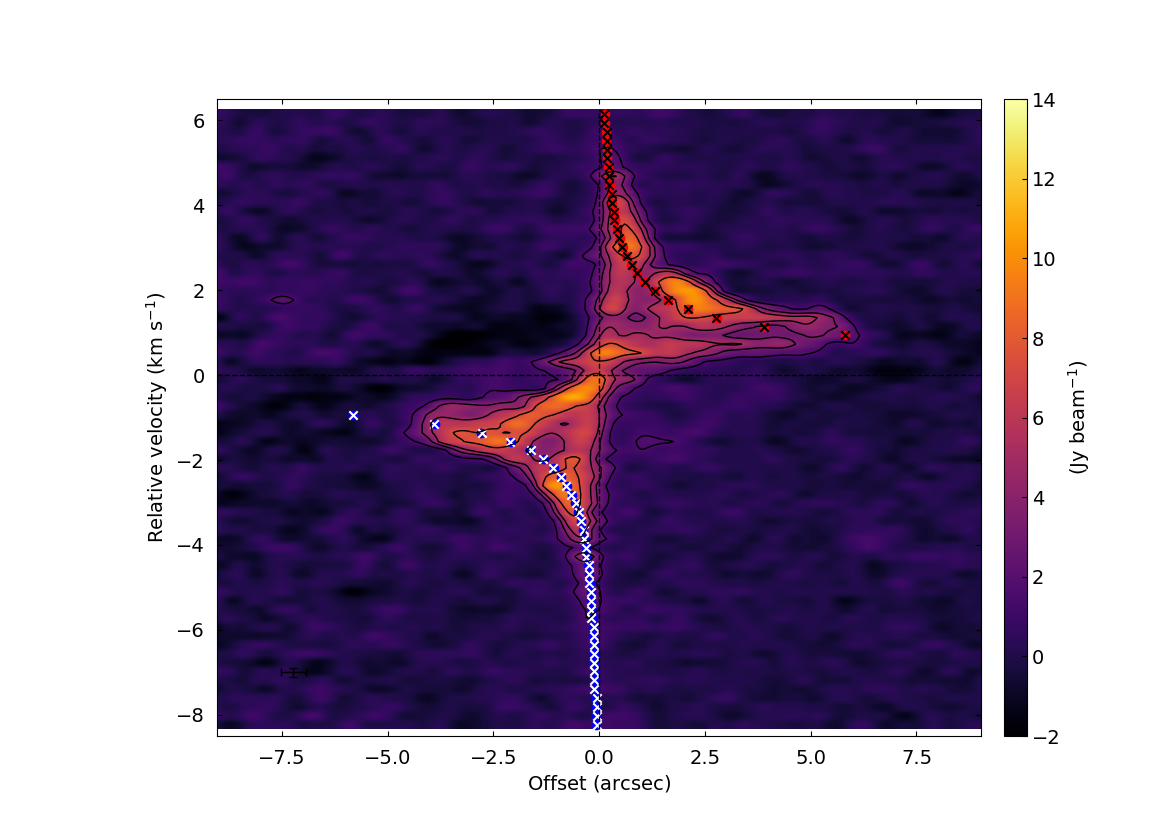

In [8]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop(fix v)

In [10]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.094e-01 arcsec, v =  4.06 Kmps , Tb7 = 7.1, Tb6 = 6.2


100%|██████████| 10000/10000 [00:13<00:00, 724.85it/s]


11.5 21.5 4.0 4.8
17.7 21.5 6.4 5.9
35.4 21.5 7.8 5.1
11.5 21.7 4.5 5.4
17.7 21.7 7.5 7.0
35.4 21.7 9.7 6.4
11.5 23.5 5.3 6.8
17.7 23.5 10.9 12.7
35.4 23.5 28.0 30.2


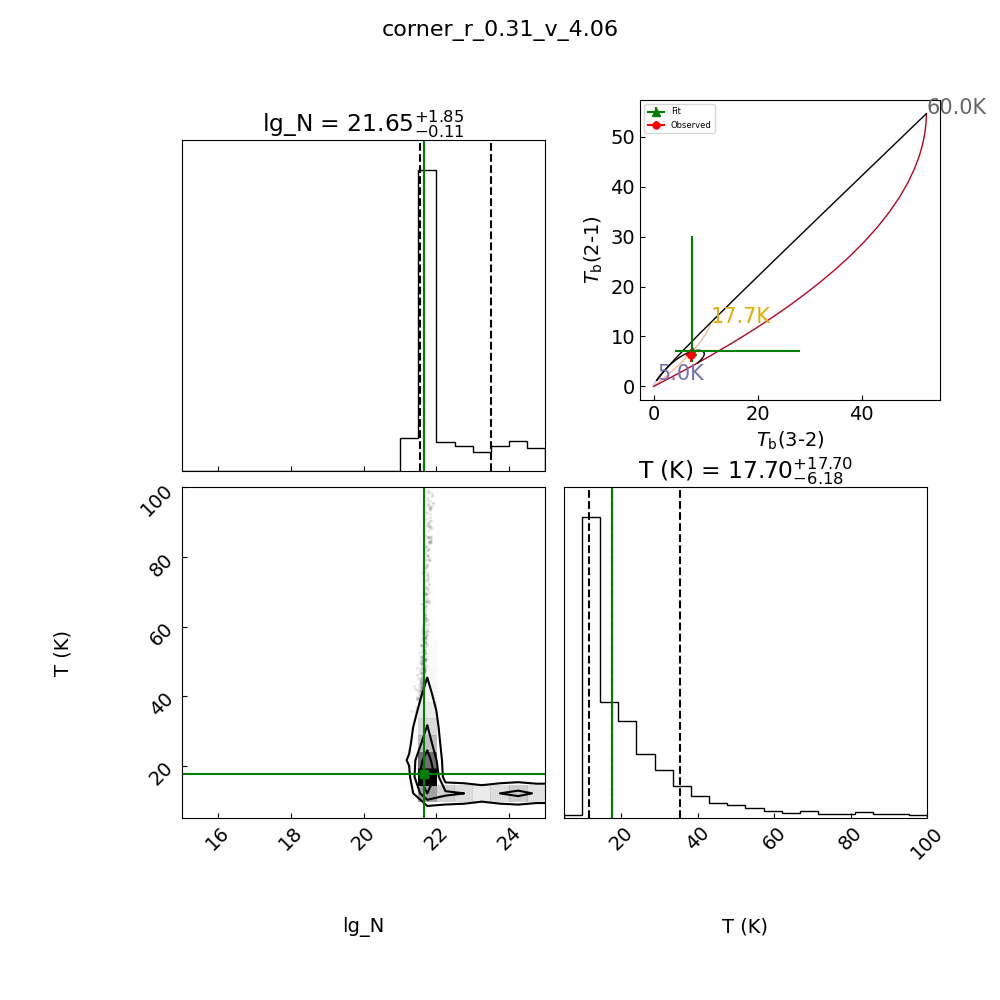

In [36]:
Texe_rs_empkep = []
Texe_upq_empkep = []
Texe_lq_empkep = []

Ncol_rs_empkep = []
Ncol_upq_empkep = []
Ncol_lq_empkep = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])

op_dir_label = "redshifted_points_empkep_test"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_sur_pt_rs"][15:16], Tb_df_b6["Tb_sur_pt_rs"][15:16], 
                          pv_b6.r_as_rs[15:16], pv_b6.v_rot_redshifted[15:16]):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                                estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep.append(T_qtls[0])
    Texe_rs_empkep.append(T_qtls[1])
    Texe_upq_empkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep.append(Ncol_qtls[0])
    Ncol_rs_empkep.append(Ncol_qtls[1])
    Ncol_upq_empkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [ ]:
# Calculate errorbars

T_err_empkep_rs = [np.array(Texe_rs_empkep)-np.array(Texe_lq_empkep),np.array(Texe_upq_empkep)-np.array(Texe_rs_empkep)] #[tl,tu] for tl,tu in zip(

N_err_empkep_rs = [np.array(Ncol_rs_empkep)-np.array(Ncol_lq_empkep), np.array(Ncol_upq_empkep)-np.array(Ncol_rs_empkep)]

In [ ]:
results_data = {"r_empkep_rs": pv_b6.r_as_rs,
        "Tb7_empkep_rs" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep" : Texe_rs_empkep, "Texe_err_rs_empkep" : np.array(T_err_empkep_rs).T.tolist(),
        "Ncol_rs_empkep" : Ncol_rs_empkep, "Ncol_err_rs_empkep" : np.array(N_err_empkep_rs).T.tolist()
        }

print(np.shape(T_err_empkep_rs))
print(len(pv_b6.r_as_rs), len(Tb_df_b7["Tb_on_point_rs"]), len(Tb_df_b6["Tb_on_point_rs"]), len( Ncol_rs_empkep),
      len(N_err_empkep_rs))
results_df = pd.DataFrame(data = results_data)

respath = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
results_df.to_csv(path_or_buf= os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv"))

(2, 26)
26 26 26 26 2


#### Visualize results

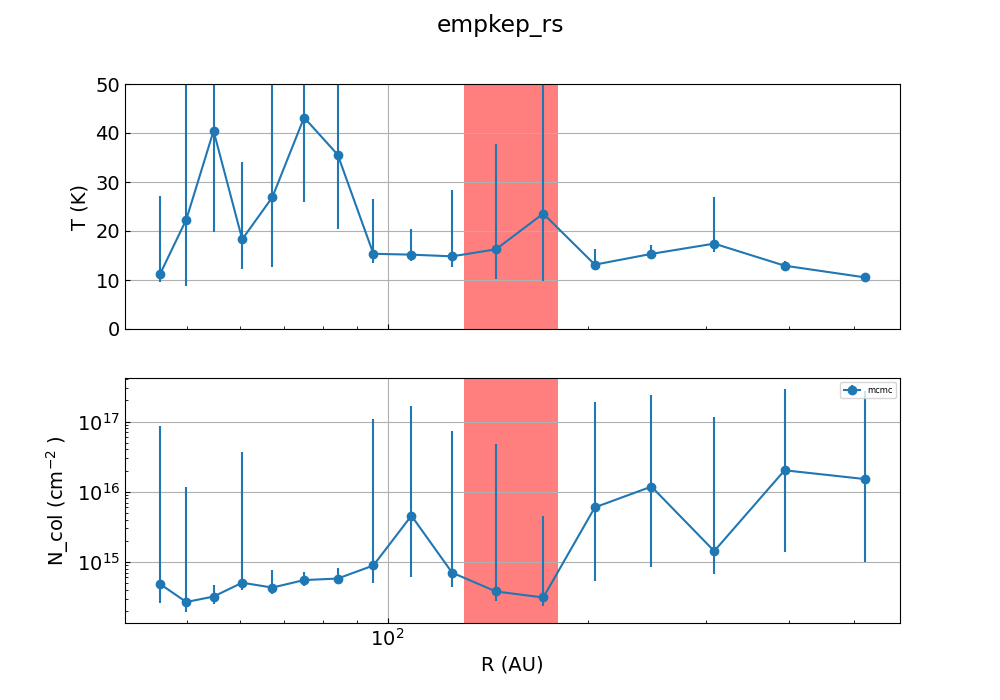

In [ ]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 5.0]

ftd_r_as_rs, ftd_Texe_rs_empkep, ftd_Terr_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Texe_rs_empkep, np.array(T_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[0].errorbar(np.array(ftd_r_as_rs)*140., ftd_Texe_rs_empkep, yerr=np.array(ftd_Terr_rs_empkep).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_rs, ftd_Ncol_rs_empkep, ftd_N_err_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep, np.array(N_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs)*140., np.array(ftd_Ncol_rs_empkep)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep).T*N_conv_fraction, marker='o', label = 'mcmc')

axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_fig.suptitle("empkep_rs")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')

### Temperature estimation (fix r)

#### Read the Data

In [5]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=7.33) # V_sys - 7.22, 7.27 7.384
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=7.33)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [6]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r

v_100 = 2.842 #kmps # idpft-2.674 # JS- 3.2 # newft 2.842

v_rot_empkep_rs_fix_r =  emp_kep_r(r=r_au_empkep_rs_fix_r, r_b=100., v_100=v_100)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [7]:
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

In [8]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, 
                                get_surrounding_pix = False, mode='vals',
                                num_pix = 3)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, 
                                    get_surrounding_pix = False, mode='vals',
                                    num_pix = 3)

#### Data Visualization

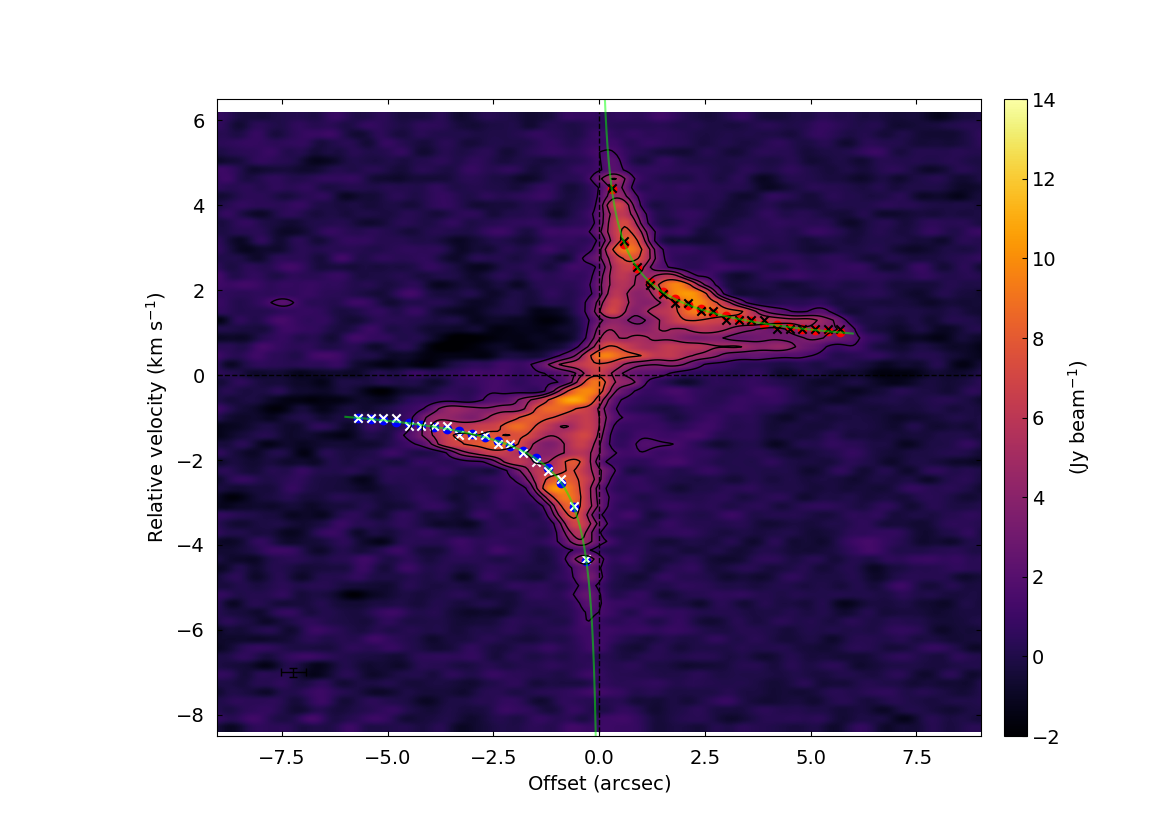

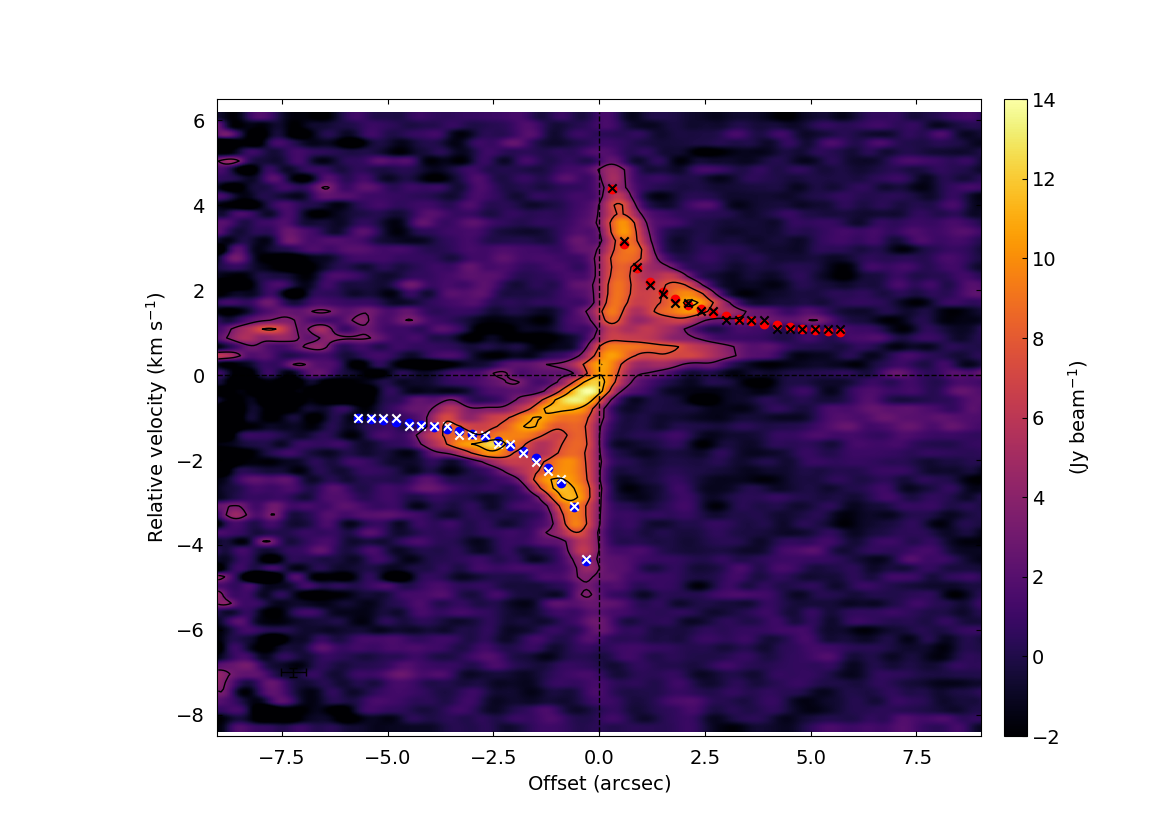

In [9]:

pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop (fix r)

In [10]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.000e-01 arcsec, v =  4.39 Kmps , Tb7 = 4.3, Tb6 = 3.6


100%|██████████| 9000/9000 [00:57<00:00, 157.02it/s]


dtauv_dT =  1.179673951422614e-05
dtauv_dT =  4.7033895364293905e-06
Tb7_dIv_dN = 2.02e-14, Tb6_dIv_dN = 1.73e-14
Tb7_dIv_dT = 0.24, Tb6_dIv_dT = 0.18
Ncols and lgNcols up 6.74e+15, lgNc = 1.58e+01
Ncols and lgNcols med 2.10e+14, lgNc = 1.43e+01
Ncols and lgNcols dwn 1.72e+14, lgNc = 1.42e+01
del T -> + 20.59, - 18.42
del N -> + 6.53e+15, - 3.73e+13
[[4.3958501  4.91323459]]
[[3.3288988  3.72070483]]


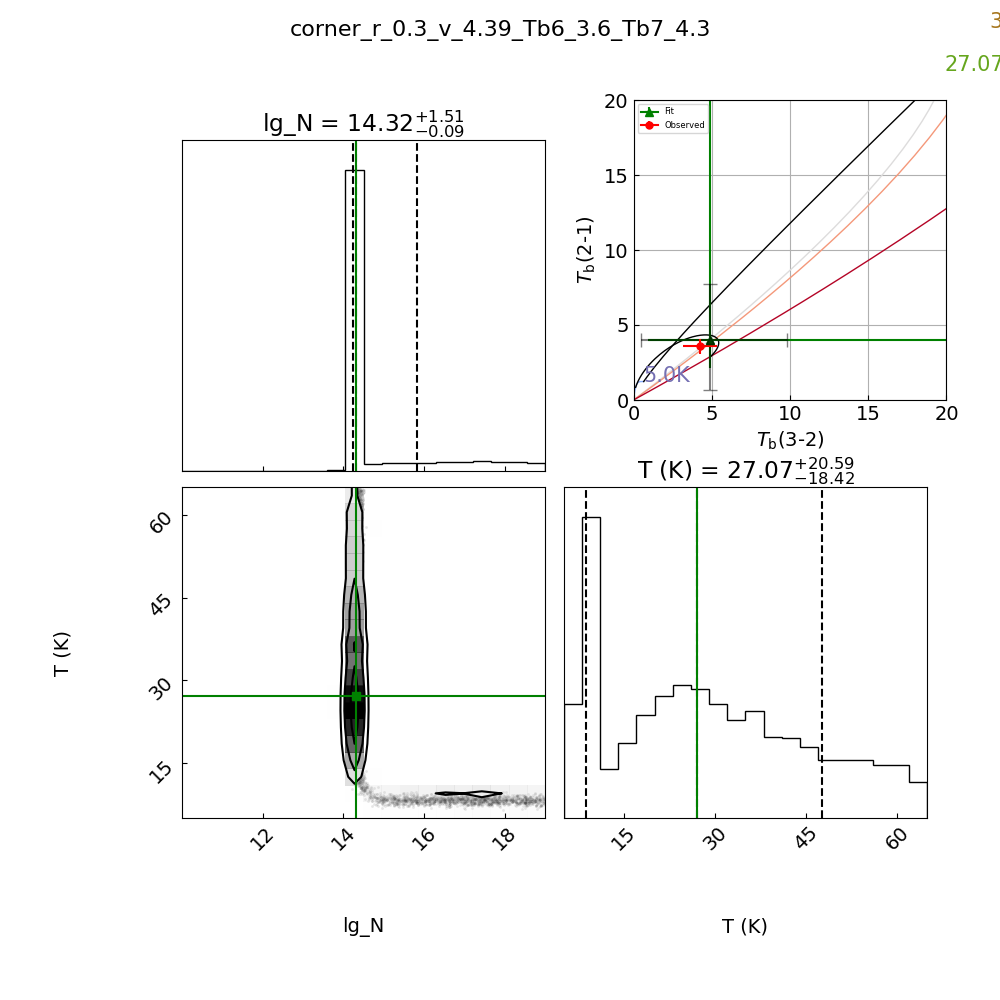

estimating for r = 6.000e-01 arcsec, v =  3.10 Kmps , Tb7 = 9.0, Tb6 = 8.0


100%|██████████| 9000/9000 [01:03<00:00, 141.75it/s]


dtauv_dT =  5.899789093931939e-05
dtauv_dT =  2.597696039010844e-05
Tb7_dIv_dN = 1.15e-14, Tb6_dIv_dN = 1.19e-14
Tb7_dIv_dT = 0.53, Tb6_dIv_dT = 0.45
Ncols and lgNcols up 4.34e+16, lgNc = 1.66e+01
Ncols and lgNcols med 5.04e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 4.51e+14, lgNc = 1.47e+01
del T -> + 8.89, - 9.82
del N -> + 4.29e+16, - 5.29e+13
[[5.19973802 4.70751226]]
[[4.46595546 4.04319218]]


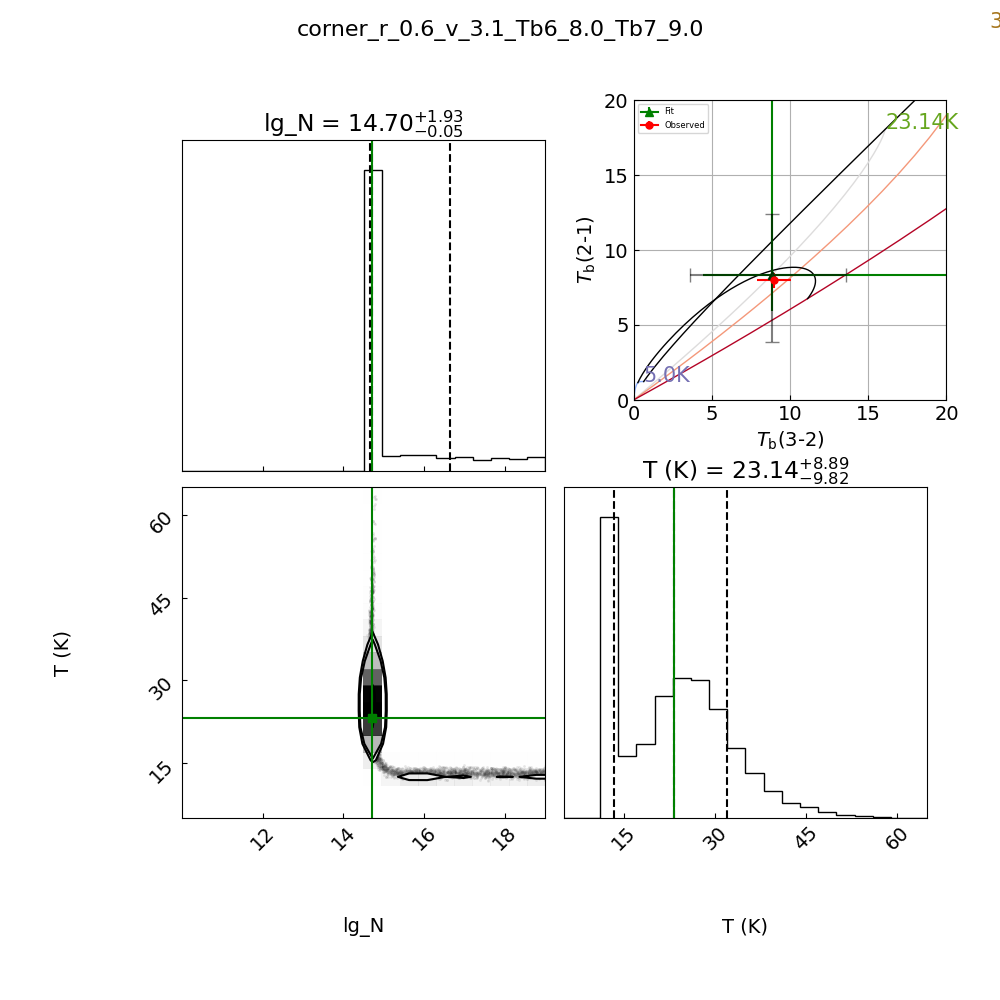

estimating for r = 9.000e-01 arcsec, v =  2.53 Kmps , Tb7 = 6.6, Tb6 = 6.1


100%|██████████| 9000/9000 [01:08<00:00, 130.74it/s]


dtauv_dT =  0.00046414309023381606
dtauv_dT =  0.0003199516687352058
Tb7_dIv_dN = 5.52e-15, Tb6_dIv_dN = 6.62e-15
Tb7_dIv_dT = 0.60, Tb6_dIv_dT = 0.68
Ncols and lgNcols up 3.64e+17, lgNc = 1.76e+01
Ncols and lgNcols med 4.96e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 3.29e+14, lgNc = 1.45e+01
del T -> + 15.25, - 3.06
del N -> + 3.63e+17, - 1.67e+14
[[1.84869848 9.21051742]]
[[ 2.06828735 10.30454497]]


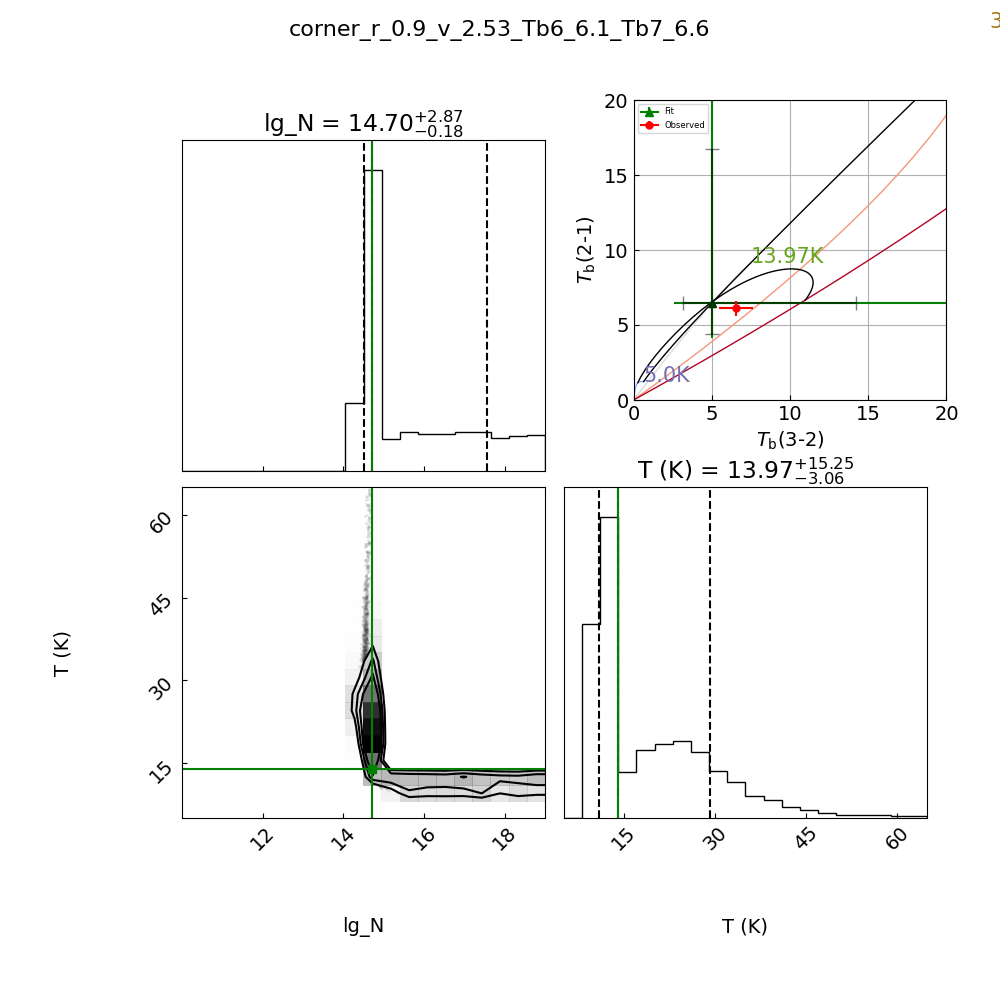

estimating for r = 1.200e+00 arcsec, v =  2.19 Kmps , Tb7 = 6.3, Tb6 = 5.4


100%|██████████| 9000/9000 [00:55<00:00, 162.82it/s]


dtauv_dT =  3.058851340751231e-05
dtauv_dT =  1.3026686314744155e-05
Tb7_dIv_dN = 1.58e-14, Tb6_dIv_dN = 1.51e-14
Tb7_dIv_dT = 0.38, Tb6_dIv_dT = 0.31
Ncols and lgNcols up 4.34e+16, lgNc = 1.66e+01
Ncols and lgNcols med 3.29e+14, lgNc = 1.45e+01
Ncols and lgNcols dwn 2.84e+14, lgNc = 1.45e+01
del T -> + 15.51, - 13.80
del N -> + 4.31e+16, - 4.48e+13
[[5.20862162 5.85160326]]
[[4.24948994 4.77407096]]


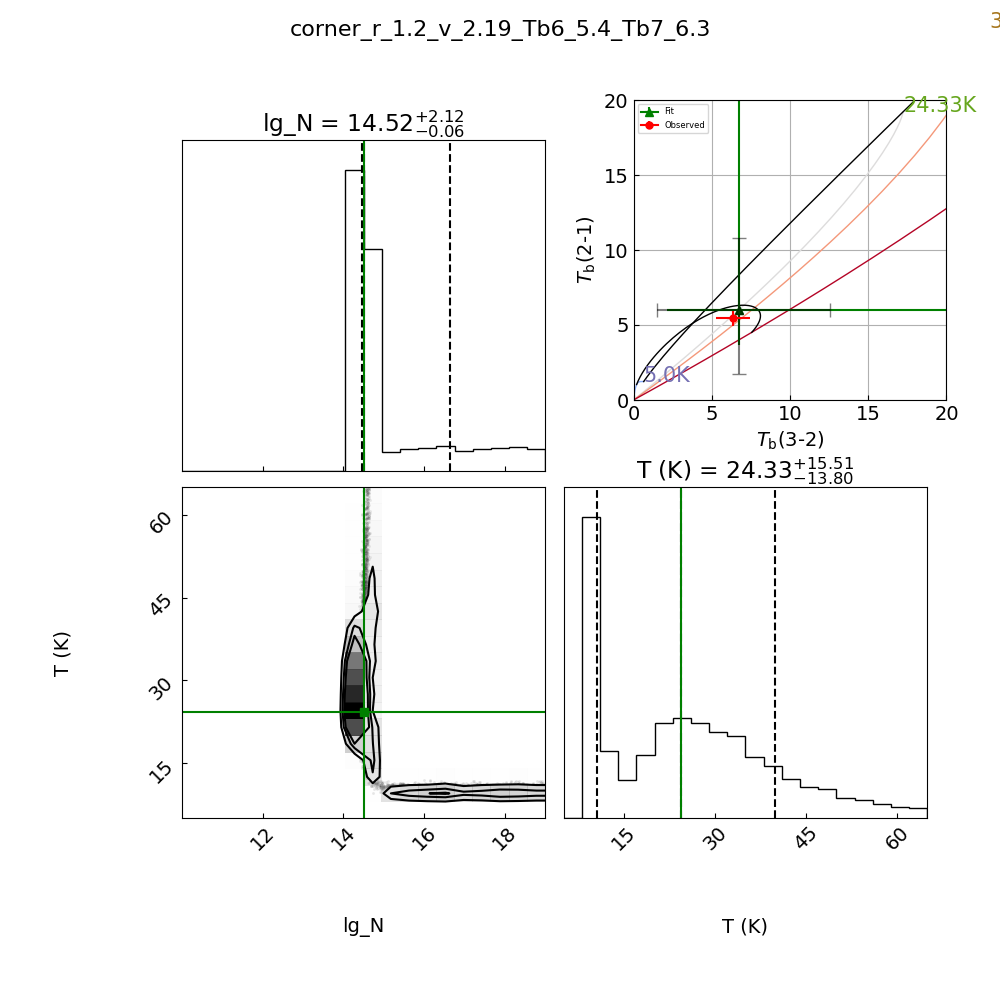

estimating for r = 1.500e+00 arcsec, v =  1.96 Kmps , Tb7 = 7.6, Tb6 = 7.3


100%|██████████| 9000/9000 [01:06<00:00, 134.97it/s]


dtauv_dT =  0.0006225748264586508
dtauv_dT =  0.00042106430325940686
Tb7_dIv_dN = 3.55e-15, Tb6_dIv_dN = 4.08e-15
Tb7_dIv_dT = 0.72, Tb6_dIv_dT = 0.78
Ncols and lgNcols up 3.90e+17, lgNc = 1.76e+01
Ncols and lgNcols med 7.08e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 4.13e+14, lgNc = 1.46e+01
del T -> + 11.78, - 2.01
del N -> + 3.89e+17, - 2.94e+14
[[1.44074158 8.4392242 ]]
[[1.57768312 9.2413669 ]]


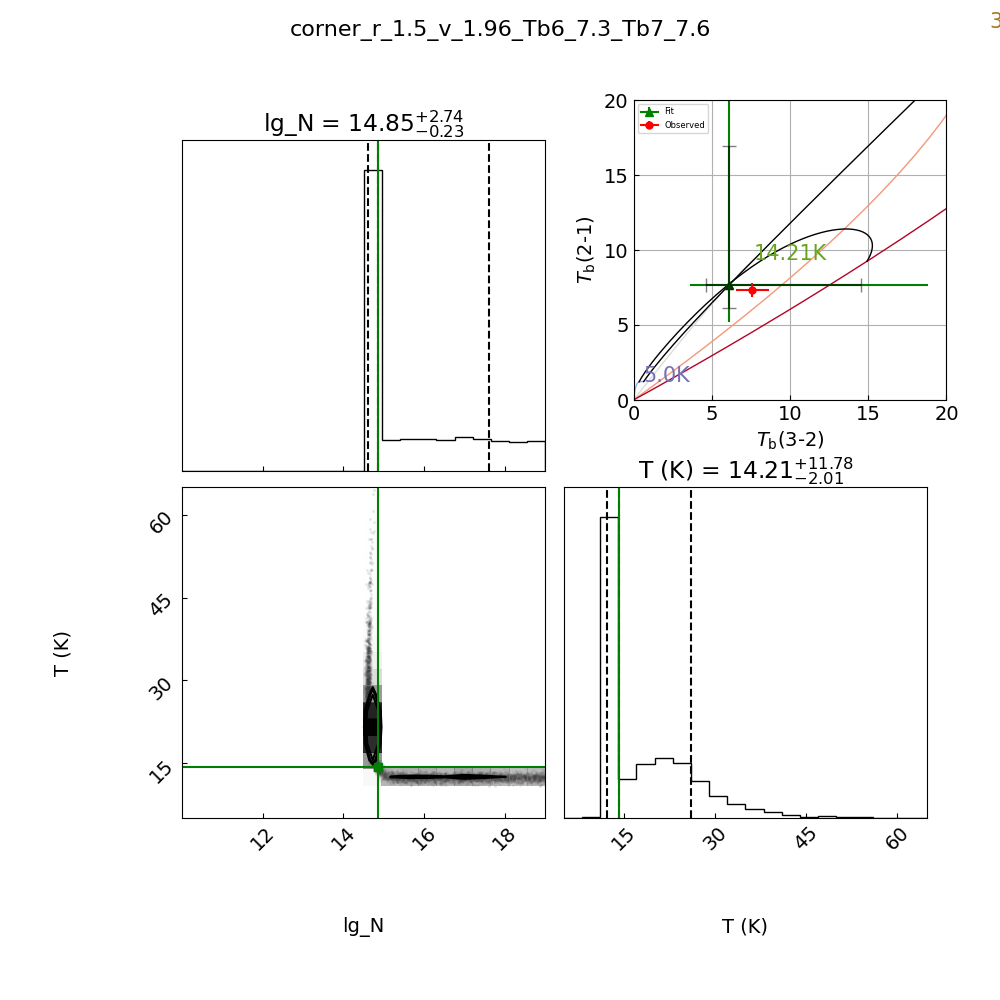

estimating for r = 1.800e+00 arcsec, v =  1.79 Kmps , Tb7 = 9.6, Tb6 = 7.3


100%|██████████| 9000/9000 [02:10<00:00, 68.76it/s]


dtauv_dT =  6.390548125961032e-06
dtauv_dT =  2.2067377150343337e-06
Tb7_dIv_dN = 1.76e-14, Tb6_dIv_dN = 1.41e-14
Tb7_dIv_dT = 0.35, Tb6_dIv_dT = 0.24
Ncols and lgNcols up 5.18e+14, lgNc = 1.47e+01
Ncols and lgNcols med 4.57e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 4.17e+14, lgNc = 1.46e+01
del T -> + 12.92, - 10.08
del N -> + 6.15e+13, - 4.01e+13
[[3.48812498 4.47252969]]
[[2.42004004 3.10301408]]


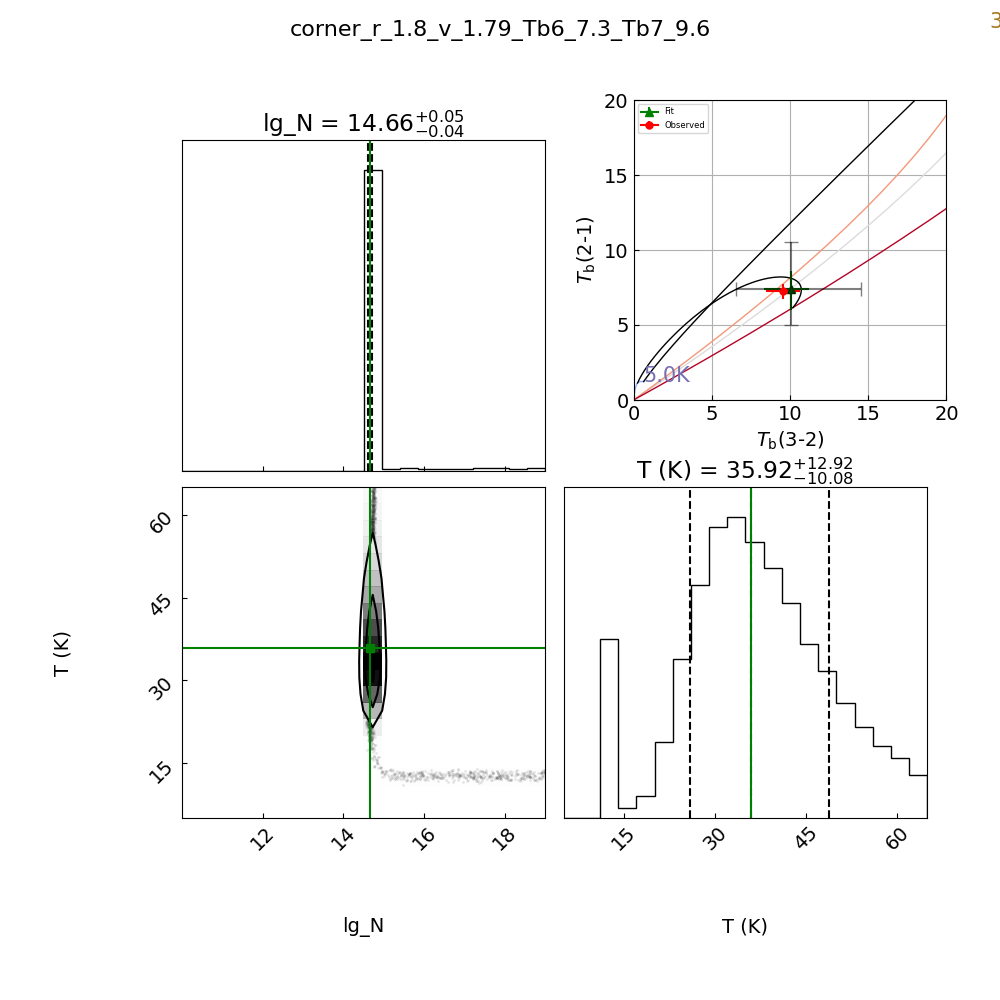

estimating for r = 2.100e+00 arcsec, v =  1.66 Kmps , Tb7 = 11.2, Tb6 = 9.8


100%|██████████| 9000/9000 [01:44<00:00, 86.25it/s] 


dtauv_dT =  3.9579676603357355e-05
dtauv_dT =  1.5983255921205674e-05
Tb7_dIv_dN = 1.11e-14, Tb6_dIv_dN = 1.13e-14
Tb7_dIv_dT = 0.57, Tb6_dIv_dT = 0.46
Ncols and lgNcols up 9.27e+14, lgNc = 1.50e+01
Ncols and lgNcols med 6.34e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 5.86e+14, lgNc = 1.48e+01
del T -> + 6.90, - 9.06
del N -> + 2.92e+14, - 4.88e+13
[[5.12387136 3.90117012]]
[[4.19484399 3.19383507]]


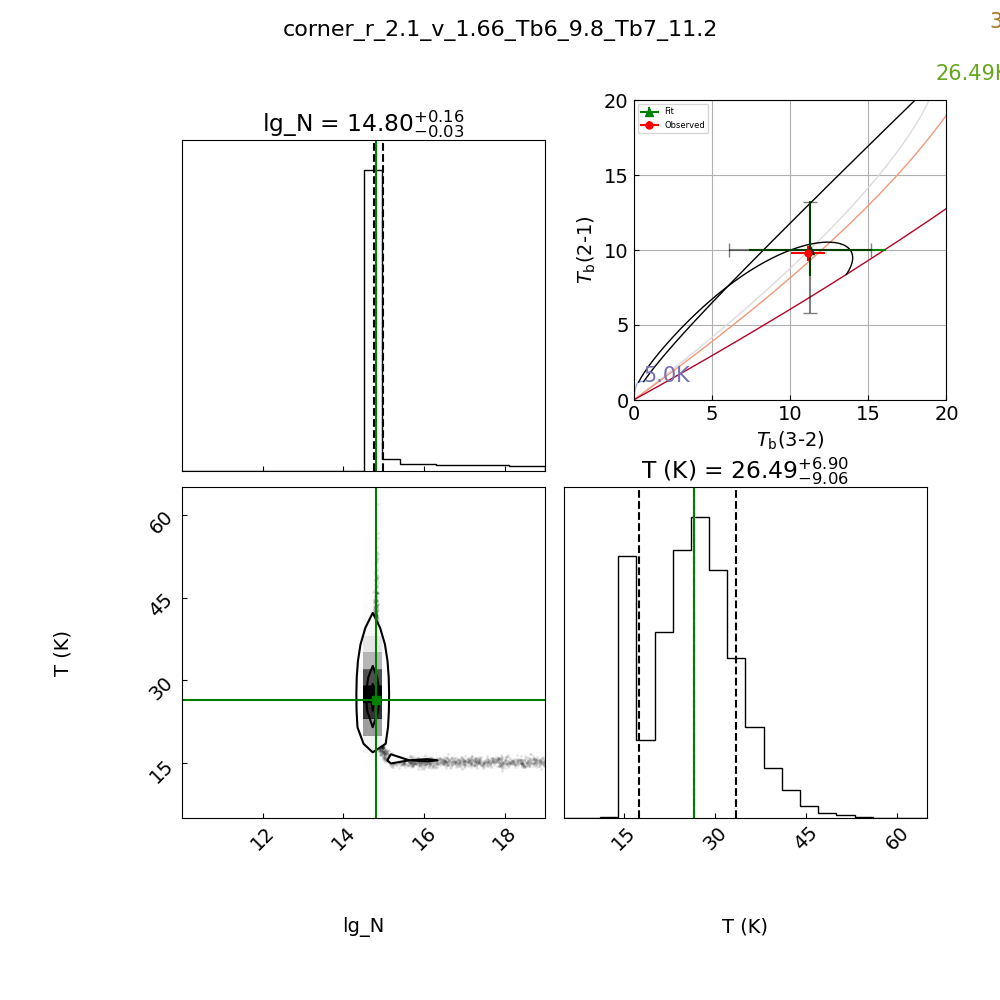

estimating for r = 2.400e+00 arcsec, v =  1.55 Kmps , Tb7 = 9.0, Tb6 = 9.5


100%|██████████| 9000/9000 [01:25<00:00, 105.41it/s]


dtauv_dT =  0.021479181691725236
dtauv_dT =  0.013976282967284374
Tb7_dIv_dN = 6.21e-41, Tb6_dIv_dN = 2.07e-42
Tb7_dIv_dT = 0.91, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 1.46e+18, lgNc = 1.82e+01
Ncols and lgNcols med 2.78e+16, lgNc = 1.64e+01
Ncols and lgNcols dwn 8.11e+14, lgNc = 1.49e+01
del T -> + 2.55, - 0.58
del N -> + 1.44e+18, - 2.70e+16
[[0.5253265  2.31728223]]
[[0.55371986 2.44252899]]


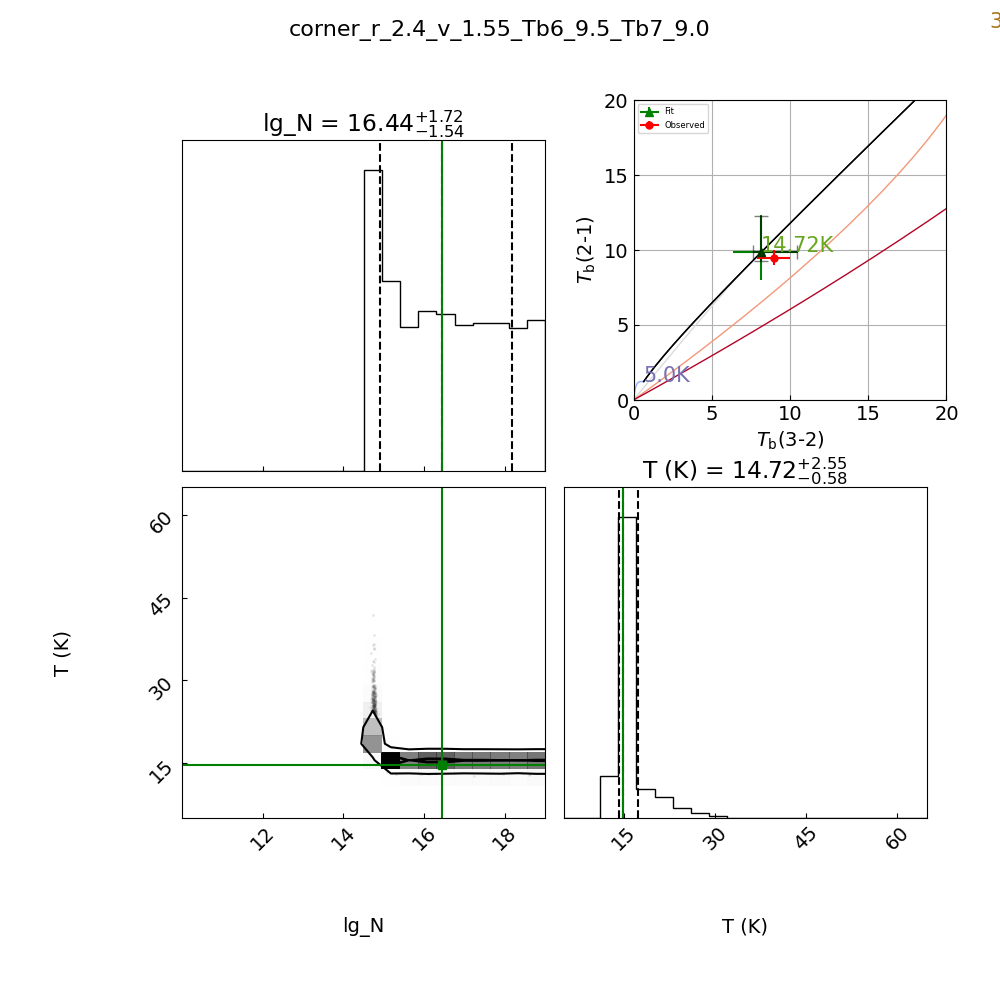

estimating for r = 2.700e+00 arcsec, v =  1.46 Kmps , Tb7 = 6.4, Tb6 = 8.8


100%|██████████| 9000/9000 [02:10<00:00, 69.06it/s]


dtauv_dT =  0.06447125167037354
dtauv_dT =  0.04595969955529086
Tb7_dIv_dN = 2.42e-75, Tb6_dIv_dN = 1.30e-83
Tb7_dIv_dT = 0.89, Tb6_dIv_dT = 0.95
Ncols and lgNcols up 2.09e+18, lgNc = 1.83e+01
Ncols and lgNcols med 6.21e+16, lgNc = 1.68e+01
Ncols and lgNcols dwn 1.77e+15, lgNc = 1.52e+01
del T -> + 0.65, - 0.51
del N -> + 2.02e+18, - 6.03e+16
[[0.45816455 0.58390218]]
[[0.48738251 0.62113866]]


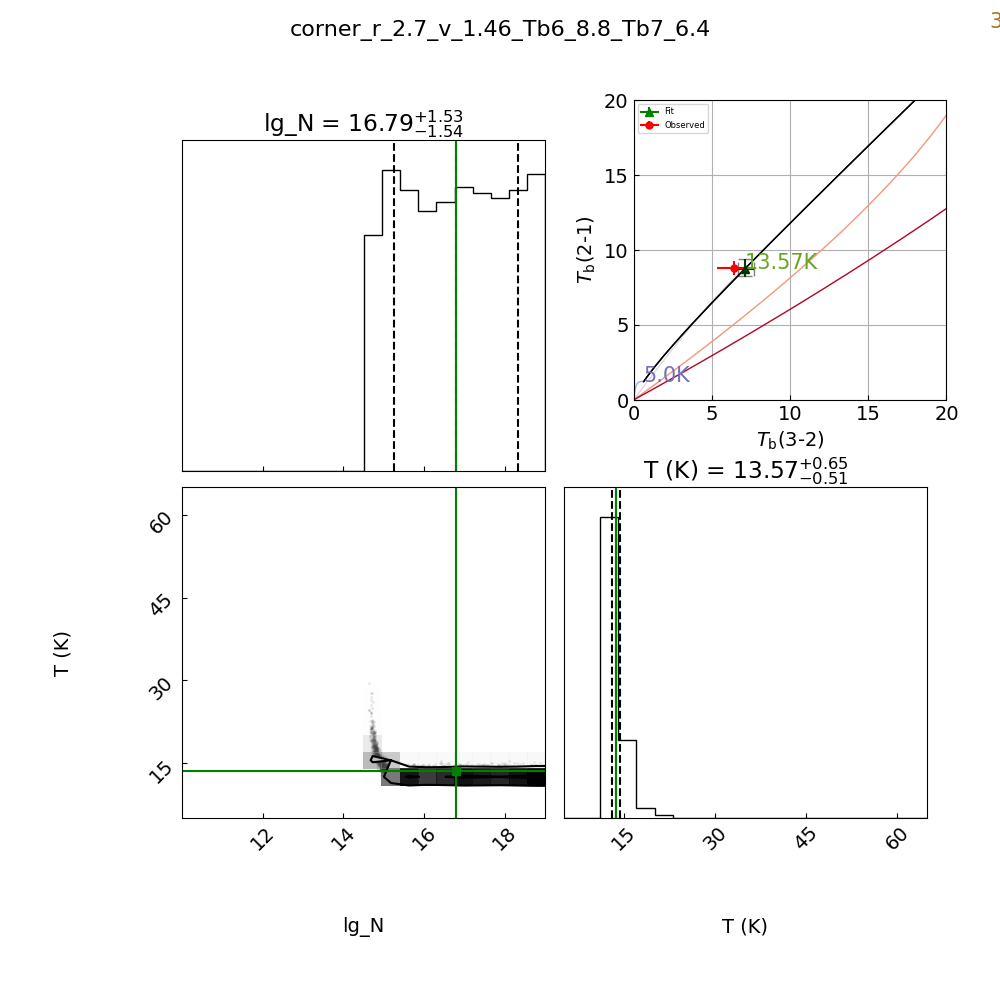

estimating for r = 3.000e+00 arcsec, v =  1.39 Kmps , Tb7 = 2.7, Tb6 = 6.6


100%|██████████| 9000/9000 [00:53<00:00, 168.55it/s]


dtauv_dT =  0.05887756457418786
dtauv_dT =  0.05494350157202072
Tb7_dIv_dN = 1.32e-43, Tb6_dIv_dN = 5.32e-55
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.93
Ncols and lgNcols up 1.43e+18, lgNc = 1.82e+01
Ncols and lgNcols med 2.88e+16, lgNc = 1.65e+01
Ncols and lgNcols dwn 7.87e+14, lgNc = 1.49e+01
del T -> + 0.81, - 0.56
del N -> + 1.40e+18, - 2.80e+16
[[0.47143745 0.68142643]]
[[0.51735976 0.74780358]]


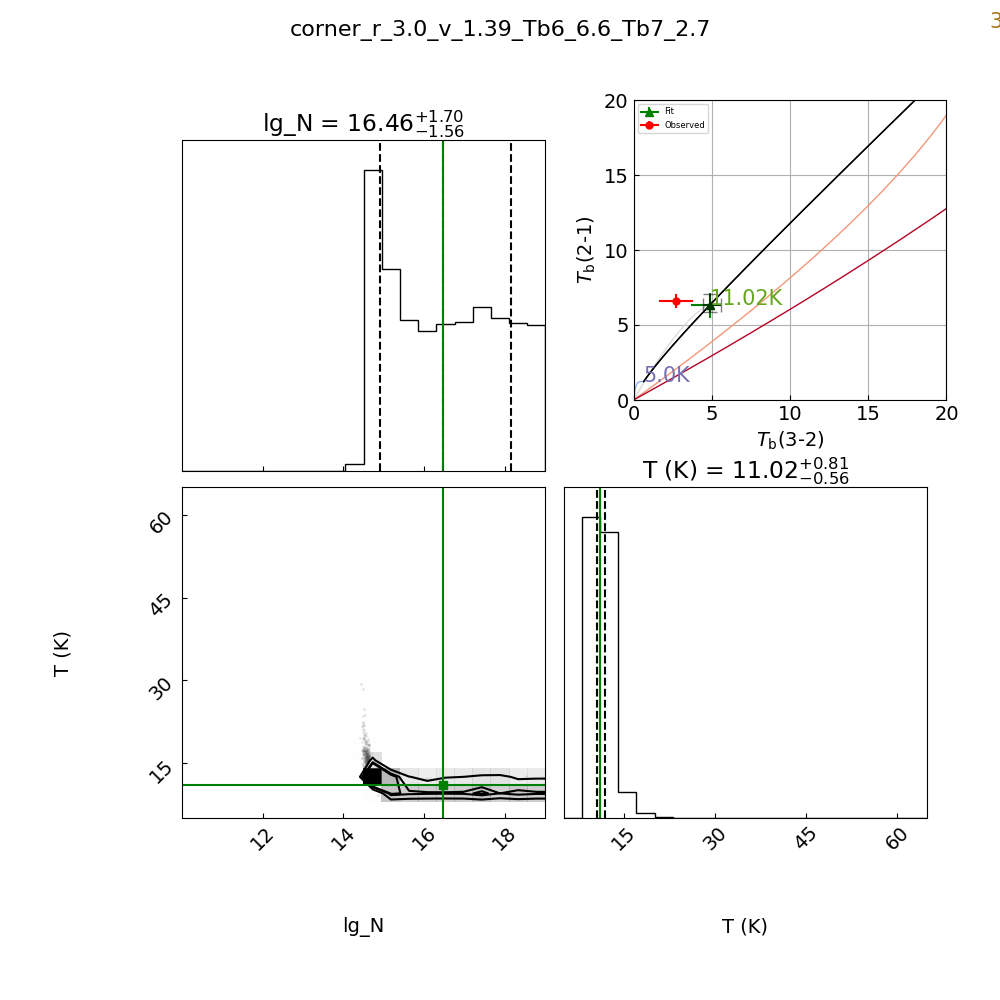

estimating for r = 3.300e+00 arcsec, v =  1.32 Kmps , Tb7 = 2.9, Tb6 = 6.5


100%|██████████| 9000/9000 [00:51<00:00, 173.68it/s]


dtauv_dT =  0.0641452267169635
dtauv_dT =  0.060332453886388276
Tb7_dIv_dN = 1.11e-45, Tb6_dIv_dN = 3.58e-58
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.93
Ncols and lgNcols up 1.52e+18, lgNc = 1.82e+01
Ncols and lgNcols med 3.09e+16, lgNc = 1.65e+01
Ncols and lgNcols dwn 8.24e+14, lgNc = 1.49e+01
del T -> + 0.82, - 0.55
del N -> + 1.49e+18, - 3.00e+16
[[0.46713411 0.69276347]]
[[0.5131497  0.76100496]]


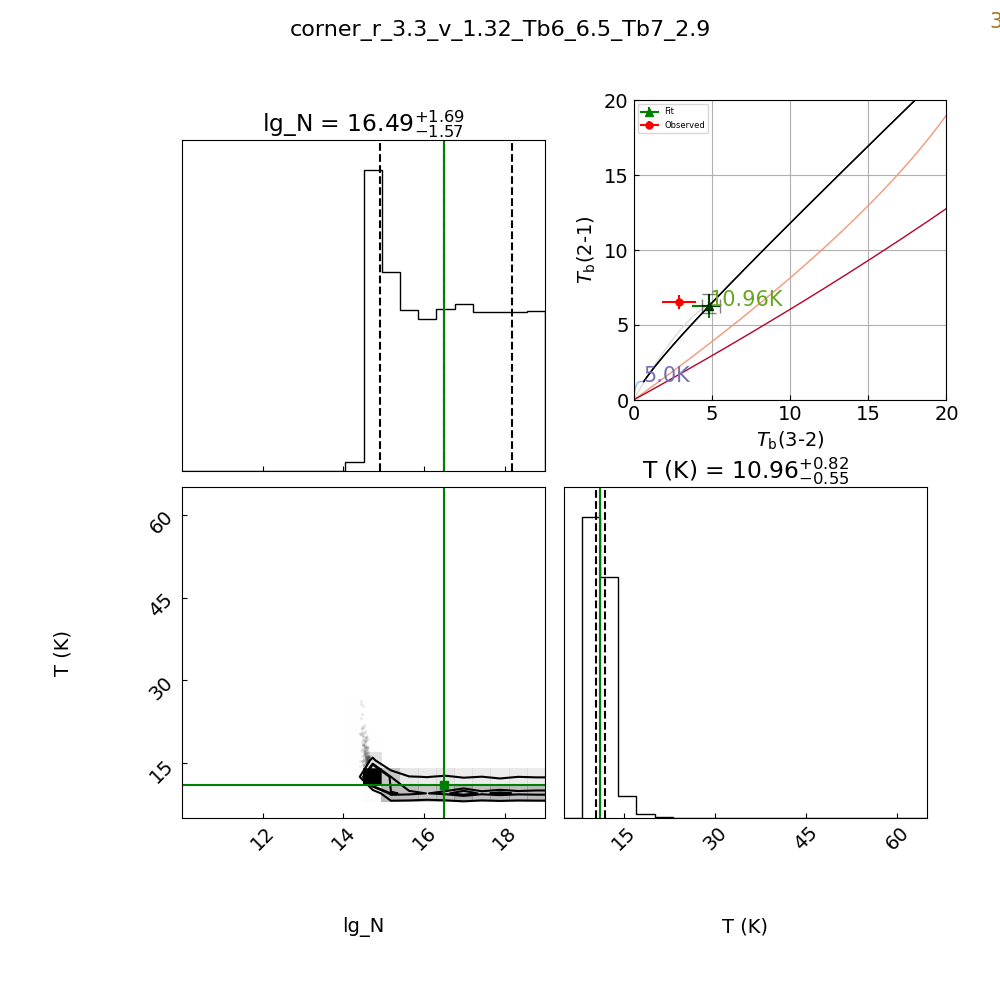

estimating for r = 3.600e+00 arcsec, v =  1.27 Kmps , Tb7 = 2.9, Tb6 = 6.6


100%|██████████| 9000/9000 [00:52<00:00, 170.67it/s]


dtauv_dT =  0.05016519819490497
dtauv_dT =  0.04687628806006754
Tb7_dIv_dN = 2.96e-39, Tb6_dIv_dN = 6.22e-49
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.93
Ncols and lgNcols up 1.45e+18, lgNc = 1.82e+01
Ncols and lgNcols med 2.45e+16, lgNc = 1.64e+01
Ncols and lgNcols dwn 7.71e+14, lgNc = 1.49e+01
del T -> + 0.84, - 0.55
del N -> + 1.43e+18, - 2.37e+16
[[0.46376027 0.71232623]]
[[0.50902144 0.78184646]]


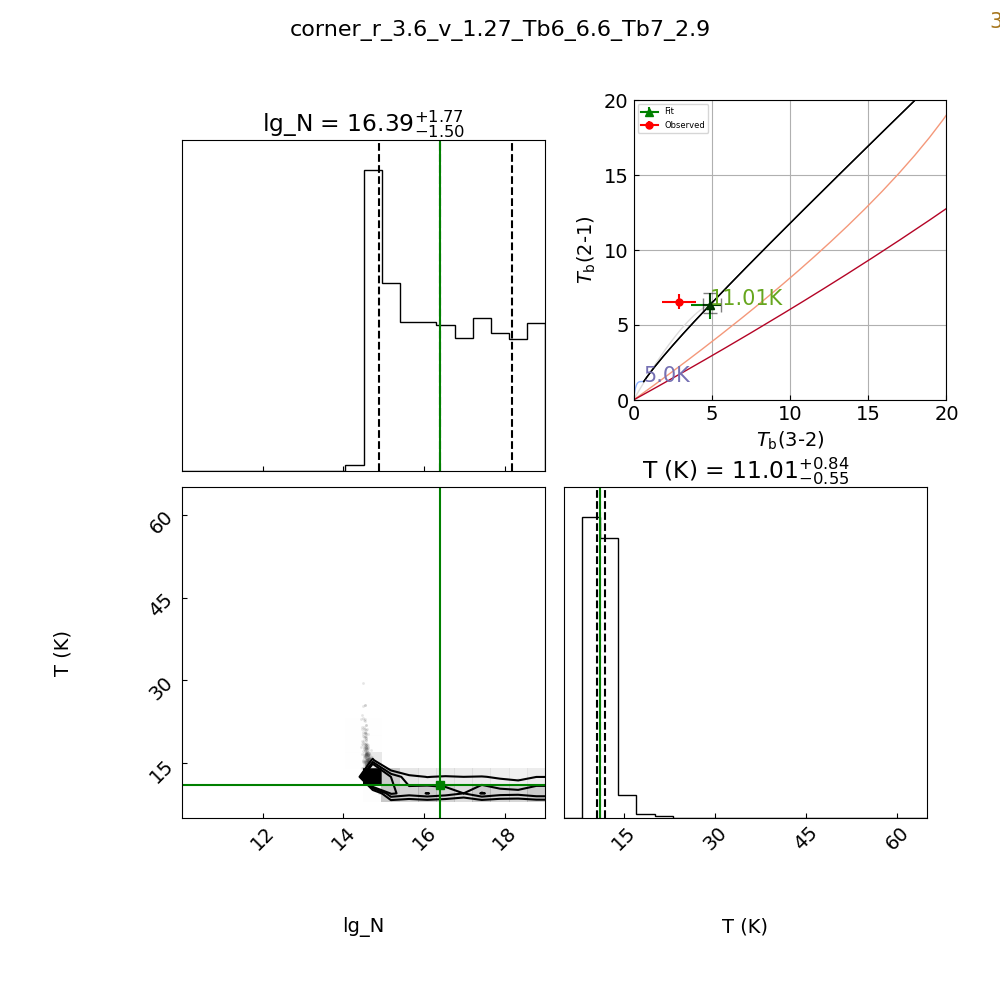

estimating for r = 3.900e+00 arcsec, v =  1.22 Kmps , Tb7 = 3.0, Tb6 = 6.3


100%|██████████| 9000/9000 [00:52<00:00, 169.81it/s]


dtauv_dT =  0.060812316683312544
dtauv_dT =  0.058308783486523526
Tb7_dIv_dN = 6.24e-43, Tb6_dIv_dN = 7.15e-55
Tb7_dIv_dT = 0.84, Tb6_dIv_dT = 0.92
Ncols and lgNcols up 1.62e+18, lgNc = 1.82e+01
Ncols and lgNcols med 2.81e+16, lgNc = 1.64e+01
Ncols and lgNcols dwn 7.31e+14, lgNc = 1.49e+01
del T -> + 0.89, - 0.57
del N -> + 1.59e+18, - 2.74e+16
[[0.48011226 0.74305339]]
[[0.52870632 0.81826077]]


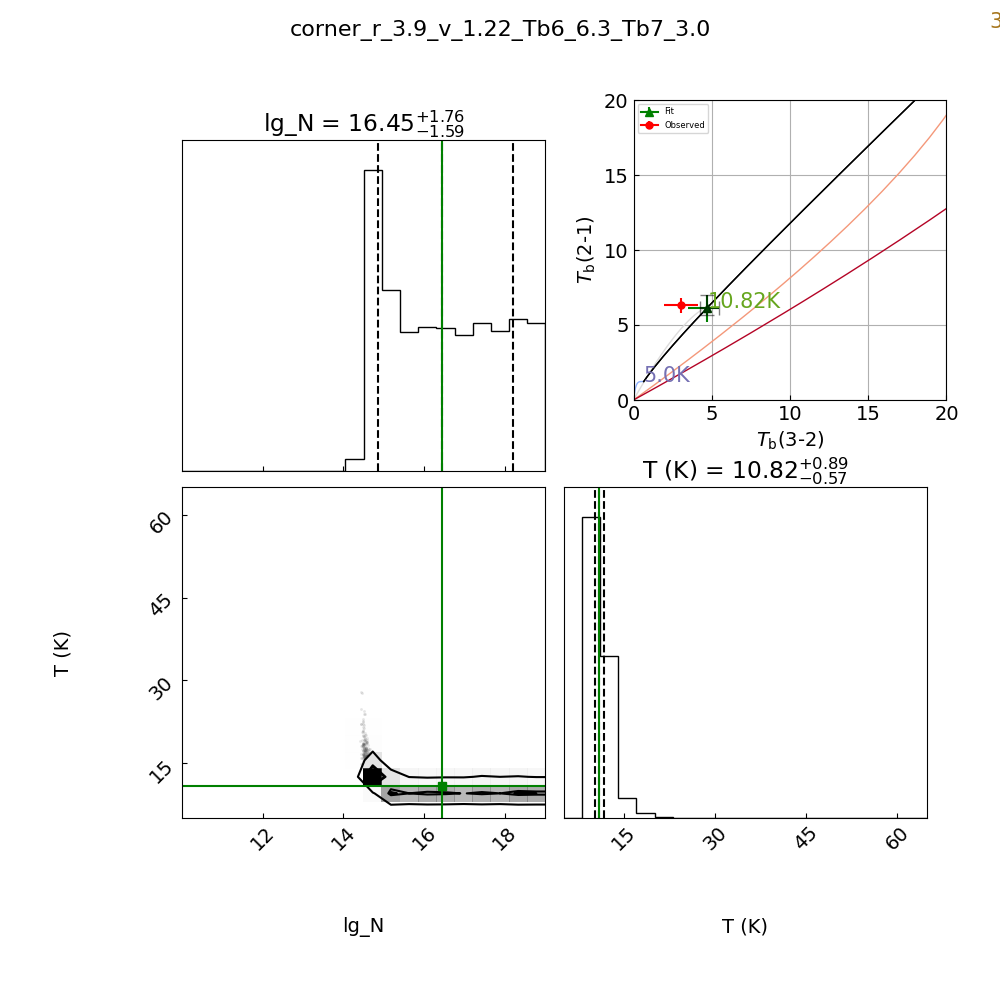

estimating for r = 4.200e+00 arcsec, v =  1.17 Kmps , Tb7 = 0.4, Tb6 = 3.0


100%|██████████| 9000/9000 [00:54<00:00, 163.99it/s]


dtauv_dT =  0.012930458377450159
dtauv_dT =  0.024500852072259792
Tb7_dIv_dN = 3.06e-17, Tb6_dIv_dN = 1.27e-19
Tb7_dIv_dT = 0.69, Tb6_dIv_dT = 0.85
Ncols and lgNcols up 7.25e+17, lgNc = 1.79e+01
Ncols and lgNcols med 2.56e+15, lgNc = 1.54e+01
Ncols and lgNcols dwn 1.65e+14, lgNc = 1.42e+01
del T -> + 4.01, - 0.77
del N -> + 7.22e+17, - 2.39e+15
[[0.52931681 2.75353601]]
[[0.65250813 3.39438423]]


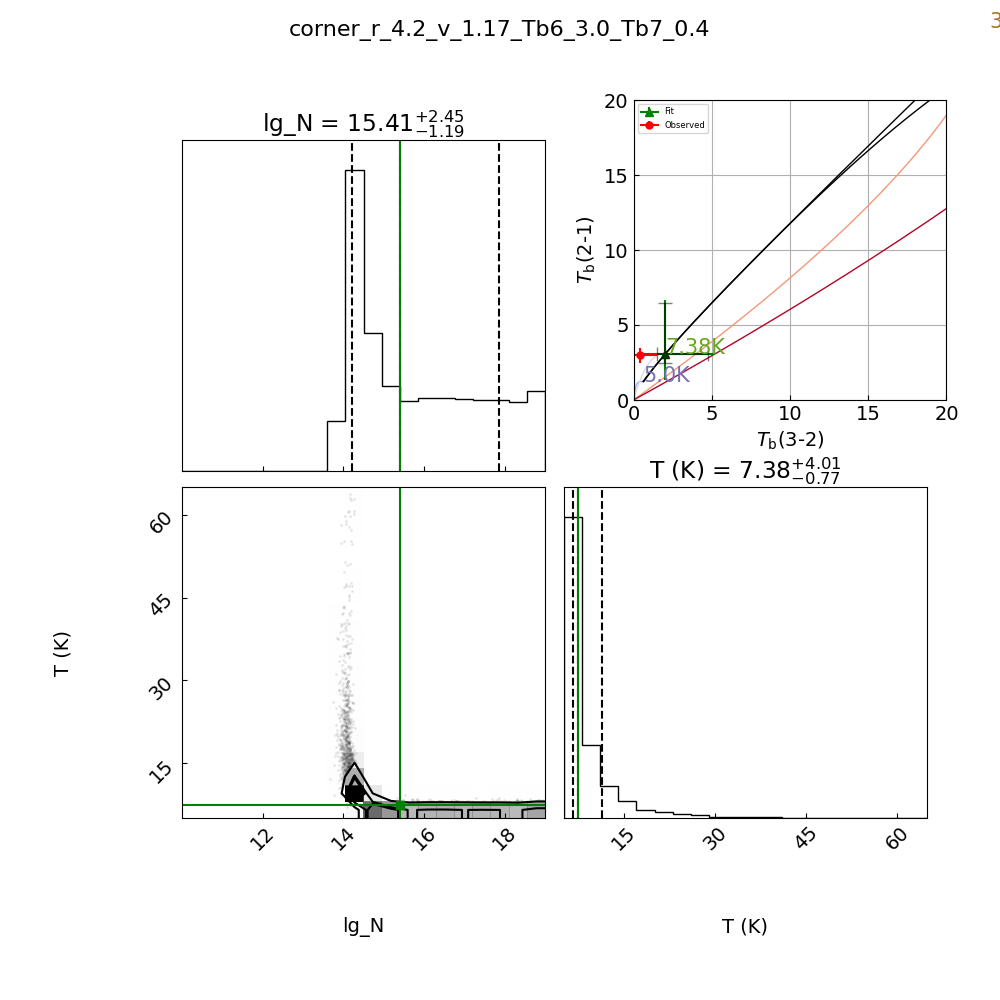

estimating for r = 4.500e+00 arcsec, v =  1.13 Kmps , Tb7 = 0.2, Tb6 = 3.7


100%|██████████| 9000/9000 [01:59<00:00, 75.42it/s]


dtauv_dT =  0.013660577653603938
dtauv_dT =  0.021906292679337774
Tb7_dIv_dN = 9.60e-18, Tb6_dIv_dN = 2.69e-20
Tb7_dIv_dT = 0.73, Tb6_dIv_dT = 0.87
Ncols and lgNcols up 7.04e+17, lgNc = 1.78e+01
Ncols and lgNcols med 3.08e+15, lgNc = 1.55e+01
Ncols and lgNcols dwn 2.65e+14, lgNc = 1.44e+01
del T -> + 2.20, - 0.69
del N -> + 7.01e+17, - 2.82e+15
[[0.50194911 1.59898736]]
[[0.59768115 1.90394722]]


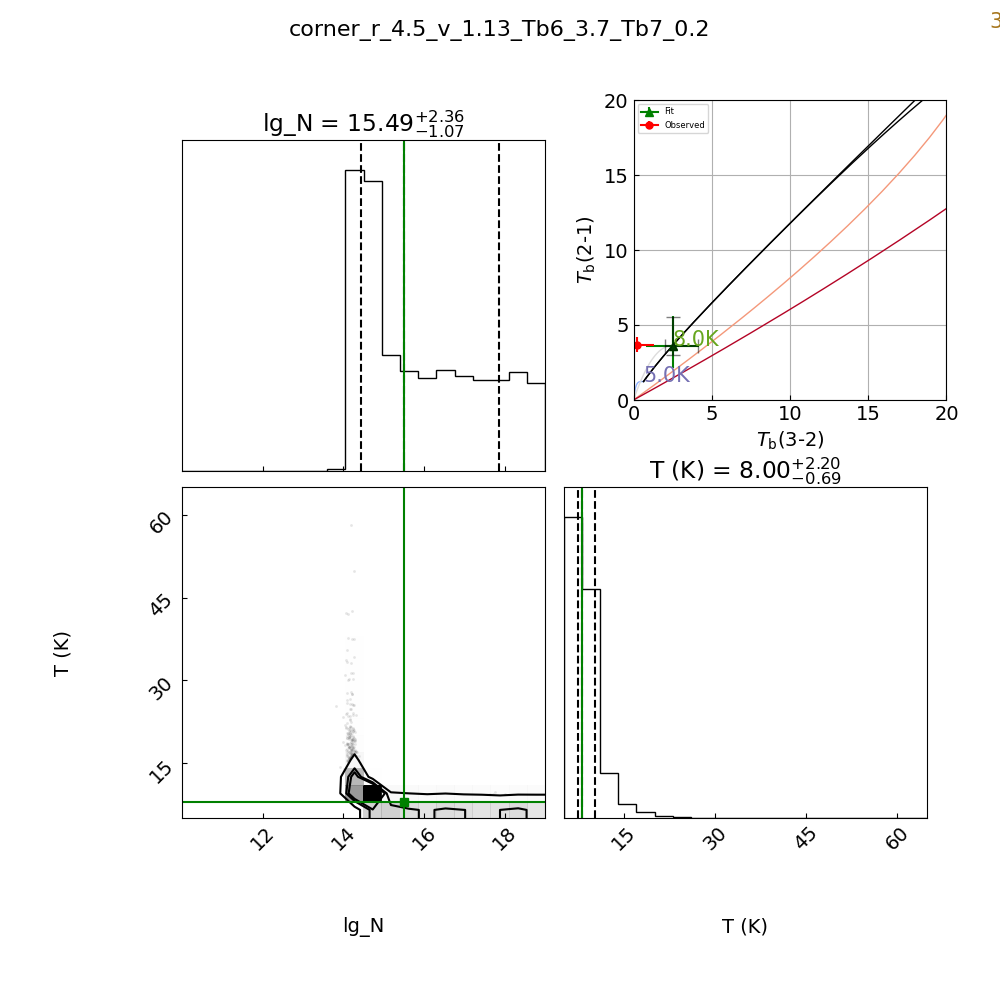

estimating for r = 4.800e+00 arcsec, v =  1.10 Kmps , Tb7 = 1.0, Tb6 = 4.5


100%|██████████| 9000/9000 [00:51<00:00, 173.75it/s]


dtauv_dT =  0.03576533712108372
dtauv_dT =  0.04753764224277136
Tb7_dIv_dN = 3.42e-24, Tb6_dIv_dN = 1.43e-31
Tb7_dIv_dT = 0.77, Tb6_dIv_dT = 0.89
Ncols and lgNcols up 1.08e+18, lgNc = 1.80e+01
Ncols and lgNcols med 9.87e+15, lgNc = 1.60e+01
Ncols and lgNcols dwn 3.89e+14, lgNc = 1.46e+01
del T -> + 1.50, - 0.60
del N -> + 1.07e+18, - 9.48e+15
[[0.46654989 1.15988669]]
[[0.53805706 1.3376602 ]]


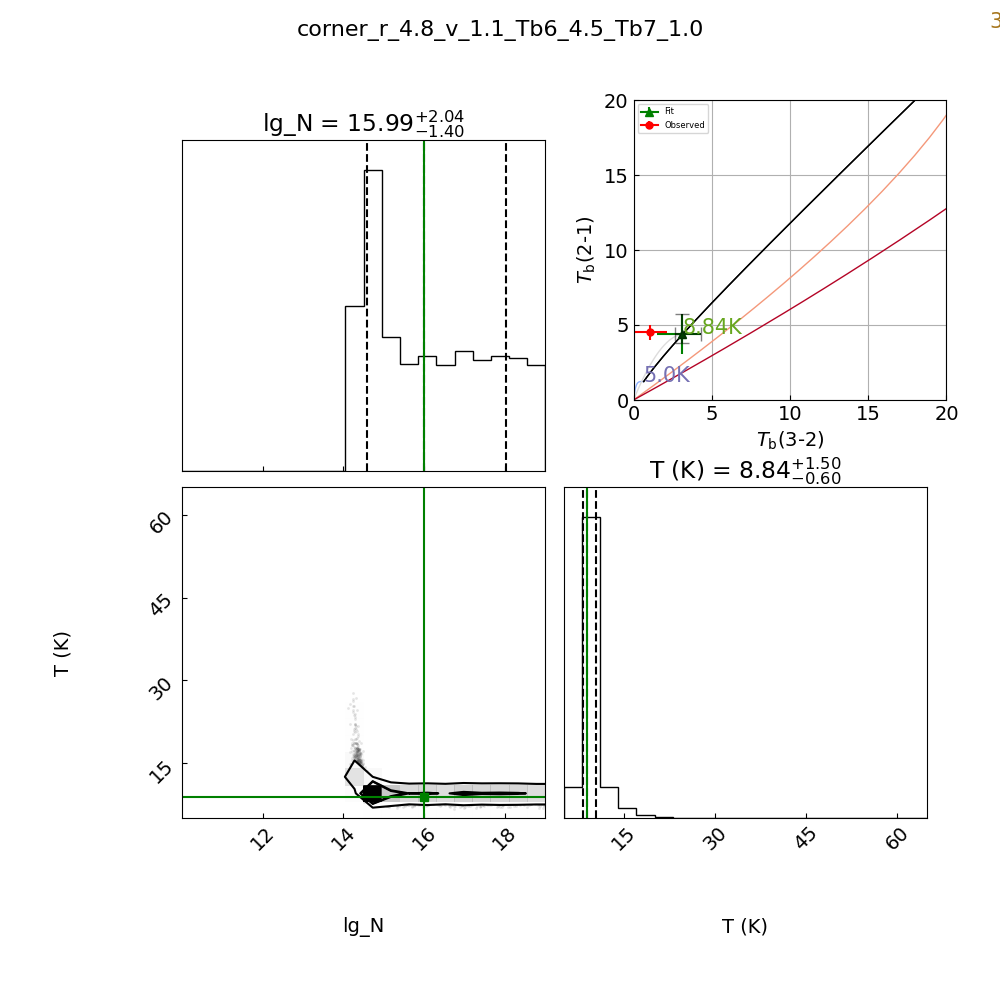

estimating for r = 5.100e+00 arcsec, v =  1.06 Kmps , Tb7 = 1.2, Tb6 = 4.3


100%|██████████| 9000/9000 [00:51<00:00, 174.73it/s]


dtauv_dT =  0.04172958409570942
dtauv_dT =  0.057469465336510116
Tb7_dIv_dN = 3.35e-25, Tb6_dIv_dN = 6.67e-34
Tb7_dIv_dT = 0.76, Tb6_dIv_dT = 0.89
Ncols and lgNcols up 1.14e+18, lgNc = 1.81e+01
Ncols and lgNcols med 1.10e+16, lgNc = 1.60e+01
Ncols and lgNcols dwn 3.64e+14, lgNc = 1.46e+01
del T -> + 1.59, - 0.62
del N -> + 1.13e+18, - 1.07e+16
[[0.47273963 1.21770095]]
[[0.54820619 1.41209062]]


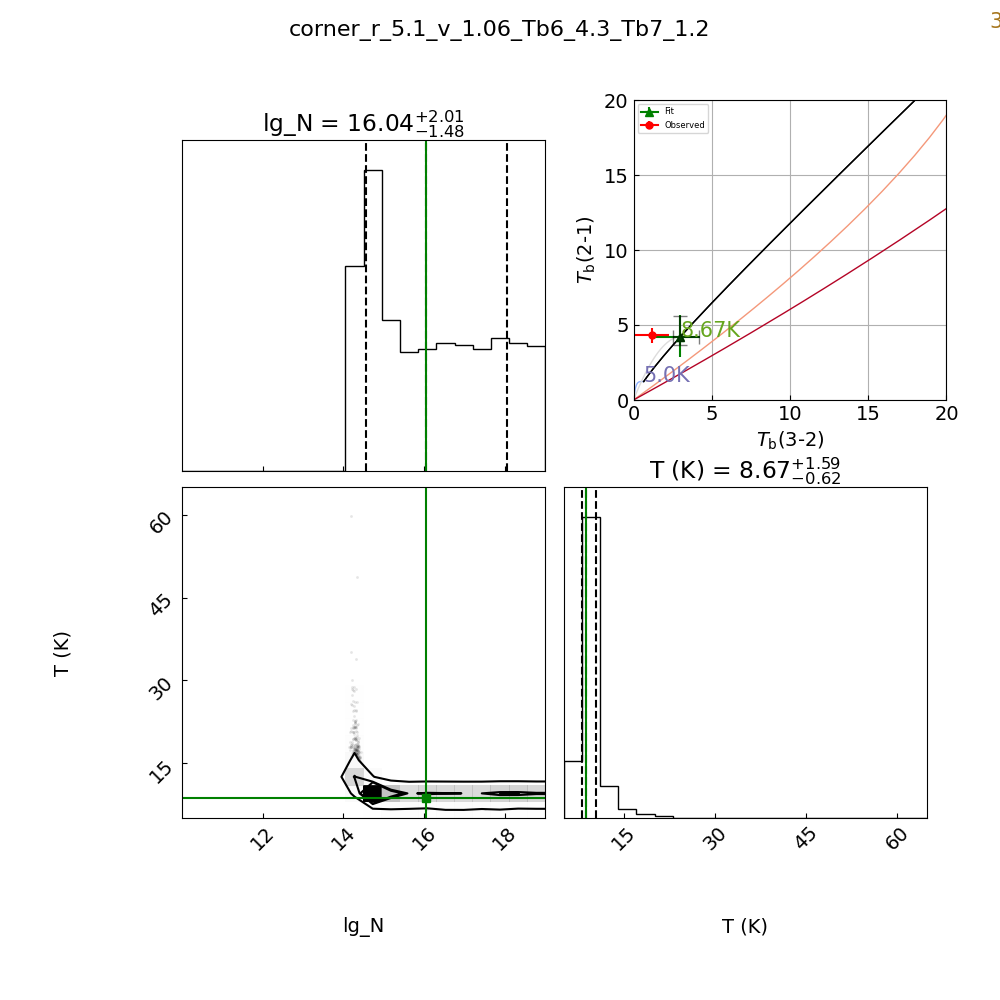

estimating for r = 5.400e+00 arcsec, v =  1.03 Kmps , Tb7 = 0.5, Tb6 = 3.7


100%|██████████| 9000/9000 [00:52<00:00, 170.09it/s]


dtauv_dT =  0.021544474103247824
dtauv_dT =  0.034985506355582216
Tb7_dIv_dN = 2.96e-19, Tb6_dIv_dN = 1.45e-23
Tb7_dIv_dT = 0.73, Tb6_dIv_dT = 0.87
Ncols and lgNcols up 9.02e+17, lgNc = 1.80e+01
Ncols and lgNcols med 4.81e+15, lgNc = 1.57e+01
Ncols and lgNcols dwn 2.68e+14, lgNc = 1.44e+01
del T -> + 2.06, - 0.68
del N -> + 8.97e+17, - 4.54e+15
[[0.49174083 1.4976045 ]]
[[0.58573669 1.78387038]]


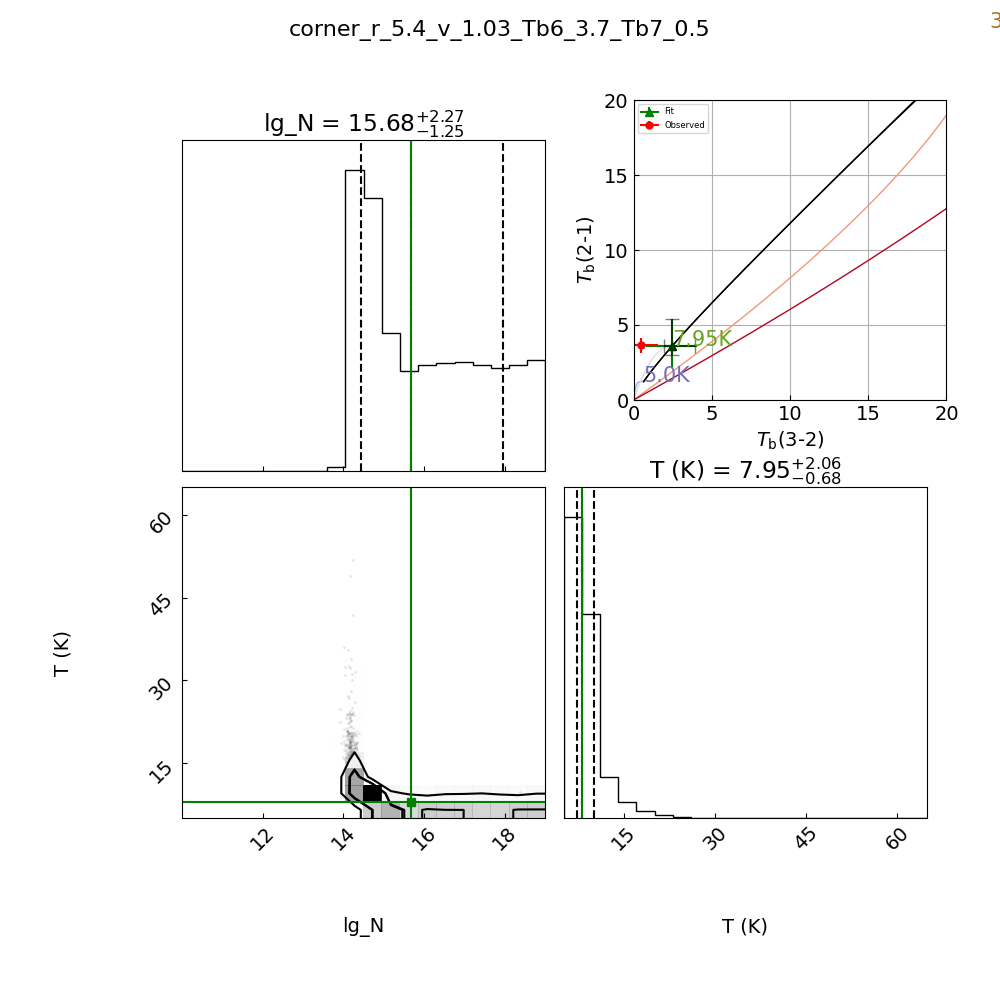

estimating for r = 5.700e+00 arcsec, v =  1.01 Kmps , Tb7 = 1.2, Tb6 = 3.3


100%|██████████| 9000/9000 [00:51<00:00, 174.19it/s]
d:\L1489_IRS_ssp\LTEAnalysis\Tb_estimator.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
C:\Users\mihirkumar\AppData\Local\Temp\ipykernel_2608\2363475668.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure(figsize=(10,10))


dtauv_dT =  0.018974449131261457
dtauv_dT =  0.03231030396223329
Tb7_dIv_dN = 1.44e-18, Tb6_dIv_dN = 2.62e-22
Tb7_dIv_dT = 0.72, Tb6_dIv_dT = 0.86
Ncols and lgNcols up 7.81e+17, lgNc = 1.79e+01
Ncols and lgNcols med 4.06e+15, lgNc = 1.56e+01
Ncols and lgNcols dwn 1.83e+14, lgNc = 1.43e+01
del T -> + 4.51, - 0.74
del N -> + 7.77e+17, - 3.88e+15
[[0.52922992 3.22710377]]
[[0.6356496  3.87602274]]


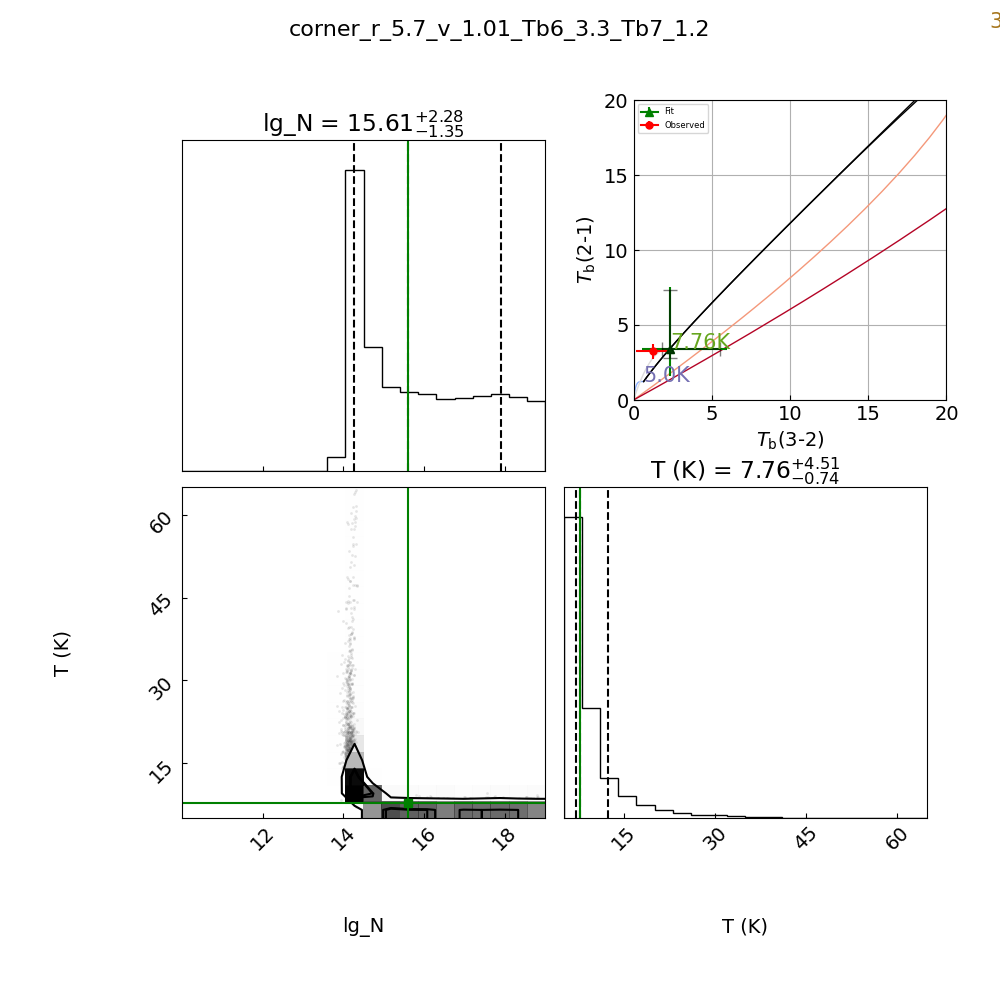

In [11]:
op_dir_label = "rs_empkep_fixr_results_rms_newcurve_lwN_bnds"

Texe_rs_empkep_fix_r = []
Texe_upq_empkep_fix_r = []
Texe_lq_empkep_fix_r = []

Ncol_rs_empkep_fix_r = []
Ncol_upq_empkep_fix_r = []
Ncol_lq_empkep_fix_r = []

plot_corner = True

np.random.seed(41)

# N_conv_fraction = 1.e-7
lg_n_bounds = [10.,19.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])


ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"], Tb_df_b6["Tb_on_point_rs"], 
                          pv_b6.r_as_rs, pv_b6.v_rot_redshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt( 1.08**2 ), #(0.1*Tb7)**2 + 1.08**2
                                                    s2=np.sqrt( 0.49**2 ),  # (0.1*Tb6)**2 + 0.49**2
                                                    estimator='mcmc', like_function = 'chisq', initial_params = [lg_n_init, T_init], 
                                                    bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                    initial_scatter = 0.1, args= None,
                                                    nwalkers = 50, n_steps = 9000, burn_in = 2000, thin_by = 50, 
                                                    return_flat= True, intensity_model = lte_model, plot_chain = True, 
                                                    r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                    chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                                                    "chains",op_dir_label),
                                                    show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep_fix_r.append(T_qtls[0])
    Texe_rs_empkep_fix_r.append(T_qtls[1])
    Texe_upq_empkep_fix_r.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep_fix_r.append(Ncol_qtls[0])
    Ncol_rs_empkep_fix_r.append(Ncol_qtls[1])
    Ncol_upq_empkep_fix_r.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)) + '_Tb6_' + str(round(Tb6,1))+ '_Tb7_' + str(round(Tb7,1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [12]:
# Calculate errorbars

T_err_empkep_rs_fix_r = [np.array(Texe_rs_empkep_fix_r)-np.array(Texe_lq_empkep_fix_r),
                         np.array(Texe_upq_empkep_fix_r)-np.array(Texe_rs_empkep_fix_r)] 

N_err_empkep_rs_fix_r = [np.array(Ncol_rs_empkep_fix_r)-np.array(Ncol_lq_empkep_fix_r), 
                         np.array(Ncol_upq_empkep_fix_r)-np.array(Ncol_rs_empkep_fix_r)]

In [13]:
results_data_fix_r = {"r_empkep_rs_fix_r": pv_b6.r_as_rs,
        "Tb7_empkep_rs_fix_r" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs_fix_r" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep_fix_r" : Texe_rs_empkep_fix_r, "Texe_err_rs_empkep_fix_r" : np.array(T_err_empkep_rs_fix_r).T.tolist(),
        "Ncol_rs_empkep_fix_r" : Ncol_rs_empkep_fix_r, "Ncol_err_rs_empkep_fix_r" : np.array(N_err_empkep_rs_fix_r).T.tolist()
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
print(res_path)
if not os.path.exists(res_path):

        df = pd.DataFrame(results_df_fix_r)
        df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_df_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

NameError: name 'res_prefix' is not defined

#### Visualize results

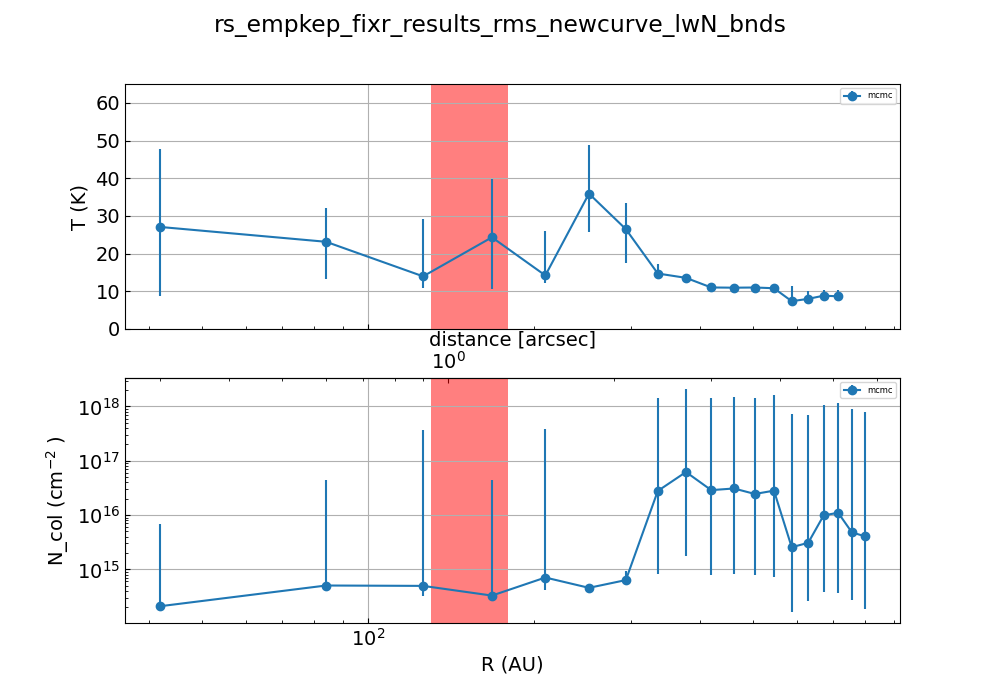

In [14]:
N_conv_fraction = 1.
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 15.0]

ftd_r_as_rs_fix_r, ftd_Texe_rs_empkep_fix_r, ftd_Terr_rs_empkep_fix_r = zip(*filter(lambda triple: acceptable_r_range[0] <= triple[0] 
                                                                                    <= 5.1, 
                                                                                    zip(pv_b6.r_as_rs, Texe_rs_empkep_fix_r, 
                                                                                        np.array(T_err_empkep_rs_fix_r).T.tolist())))

axes[0].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Texe_rs_empkep_fix_r, 
                 yerr=np.array(ftd_Terr_rs_empkep_fix_r).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,65)
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

ftd_r_as_rs_fix_r, ftd_Ncol_rs_empkep_fix_r, ftd_N_err_rs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep_fix_r, np.array(N_err_empkep_rs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(Ncol_rs_empkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")


secax = axes[1].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
secax.set_xlabel('distance [arcsec]')


vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)


if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')